In [2]:
%matplotlib inline 
%reload_ext autoreload 
%autoreload 2


from fastai.conv_learner import * 
from fastai.dataset import *

from pathlib import Path 
import json 
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

### Data Processing and Exploration

In [3]:
PATH = Path("../../Data/pascal")
list(PATH.iterdir())

[WindowsPath('../../Data/pascal/models'),
 WindowsPath('../../Data/pascal/pascal_test2007.json'),
 WindowsPath('../../Data/pascal/pascal_train2007.json'),
 WindowsPath('../../Data/pascal/pascal_train2012.json'),
 WindowsPath('../../Data/pascal/pascal_val2007.json'),
 WindowsPath('../../Data/pascal/pascal_val2012.json'),
 WindowsPath('../../Data/pascal/tmp'),
 WindowsPath('../../Data/pascal/VOC2012test'),
 WindowsPath('../../Data/pascal/VOC2012test.tar'),
 WindowsPath('../../Data/pascal/VOCtest_06-Nov-2007.tar'),
 WindowsPath('../../Data/pascal/VOCtrainval_06-Nov-2007'),
 WindowsPath('../../Data/pascal/VOCtrainval_06-Nov-2007.tar'),
 WindowsPath('../../Data/pascal/VOCtrainval_11-May-2012'),
 WindowsPath('../../Data/pascal/VOCtrainval_11-May-2012.tar')]

In [4]:
trn_j = json.load((PATH/'pascal_train2007.json').open())
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [5]:
IMAGES, ANNOTATIONS, CATEGORIES = ['images','annotations', 'categories']
FILE_NAME, ID, IMG_ID, CAT_ID, BBOX = ['file_name','id','image_id','category_id','bbox']

cats = {o[ID]:o['name'] for o in trn_j[CATEGORIES]}
trn_fns = {o[ID]:o[FILE_NAME] for o in trn_j[IMAGES]}
trn_ids = [o[ID] for o in trn_j[IMAGES]]

trn_j[CATEGORIES][:3]

[{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'},
 {'supercategory': 'none', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'none', 'id': 3, 'name': 'bird'}]

In [6]:
trn_j[ANNOTATIONS][:2]

[{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
  'area': 34104,
  'iscrowd': 0,
  'image_id': 12,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0},
 {'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]],
  'area': 13110,
  'iscrowd': 0,
  'image_id': 17,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0}]

In [7]:
JPEGS = 'VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages'
IMG_PATH = PATH/JPEGS
list(IMG_PATH.iterdir())[:3]

[WindowsPath('../../Data/pascal/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/000005.jpg'),
 WindowsPath('../../Data/pascal/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/000007.jpg'),
 WindowsPath('../../Data/pascal/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/000009.jpg')]

In [8]:
image0_data = trn_j[IMAGES][5]
image0_data[ID], image0_data[FILE_NAME]


(33, '000033.jpg')

Dictionary mapping image id to a list containing the bounding box and class id

In [9]:
def bbox_npstyle(bb):
    #takes given bounding box column, row, height, width 
    #and returns coords of top left and bottom right xy 
    return np.array([bb[1],bb[0],bb[3]+bb[1]-1, bb[2]+bb[0]-1])

trn_anno = collections.defaultdict(lambda:[])
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = bbox_npstyle(bb)
        trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))

len(trn_anno)

2501

In [10]:
image0_anno = trn_anno[image0_data[ID]]
image0_anno[0][0]

array([106,   8, 262, 498])

In [11]:
#above bboxs have id of 13 and 15, which are...
cats[13],cats[15]

('horse', 'person')

In [12]:
def bbox_vocstyle(bb):
    return np.array([bb[1], bb[0], bb[3]-bb[1]+1, bb[2]-bb[0]+1])



In [13]:
im = open_image(IMG_PATH/image0_data[FILE_NAME])

In [14]:
def show_img(im, figsize=None, ax=None):
    #returns fig and axes objects 
    if not ax:
        #useful warpper for creating one or more plot 
        fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im) #show image 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax 

def draw_outline(o,lw):
    #ensures text is white with a black outline 
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(ax,b, edgecolor='white'):
    #draw the bounding box given axes object and bounding box 
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], 
                         fill=False, edgecolor=edgecolor, lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14):
    #draw text onto image given axes object, coords, and text 
    text = ax.text(*xy, txt, verticalalignment='top', color='white',
                   fontsize=sz, weight='bold')
    draw_outline(text,1)
    
    

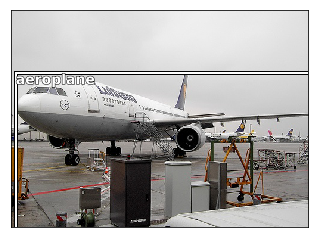

In [15]:
ax = show_img(im)
b = bbox_npstyle(image0_anno[0][0])
draw_rect(ax,b)
draw_text(ax,b[:2], cats[image0_anno[0][1]])

(364, 480, 3)


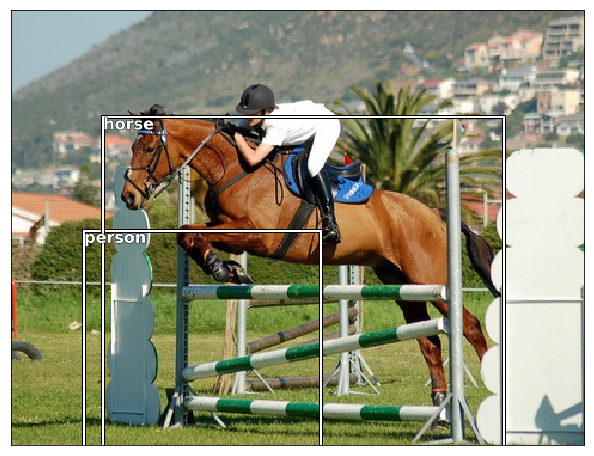

In [16]:
#Putting together above functions 
def draw_im(im,ann, figsize=(16,8), sz=16):
    ax = show_img(im, figsize=figsize)
    for box,cat in ann:
        draw_rect(ax,box)
        draw_text(ax,box[:2],cats[cat], sz=sz)
        
def draw_idx(i):
    image_data = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print (im.shape)#shape of image 
    draw_im(im, image_data)
    
draw_idx(17)

### Largest Item Classifier 


In [17]:
def get_largest(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:] - x[0][:2]), reverse=True)
    return b[0] #largest box 

In [18]:
#dict containing mapping between ID and largest bbox 
trn_lrg_anno = {a:get_largest(b) for a,b in trn_anno.items()}


In [19]:
box, cat = trn_lrg_anno[2008000291]
b = bbox_npstyle(box)
ax = show_img(open_image(IMG_PATH/trn_fns[2008000291]))
draw_rect(ax,b)
draw_text(ax,b[:2],cats[cat])

KeyError: 2008000291

In [20]:
#create a CSV mapping filename to class 
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/largest_item_classifier.csv'
df = pd.DataFrame({'fn':[trn_fns[o] for o in trn_ids],
                   'cat':[cats[trn_lrg_anno[o][1]] for o in trn_ids]},
                   columns = ['fn','cat'])
df.to_csv(CSV, index=False)

In [21]:
# Setup classifier 
f_model = resnet34
sz = 224
bs = 64 

#specify croptype because default strat may interfere with bboxes
#squishes to make square instead of cropping 
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on,
                       crop_type = CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


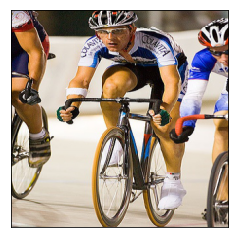

In [22]:
x,y = next(iter(md.val_dl)) #grab a single minibatch from dataloader 
show_img(md.val_ds.denorm(to_np(x))[0]) #denormalize minibatch images then show first
#notice how to_np was used to take the tensor from GPU to array on CPU 

### Resnet34 Training 

In [48]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam


 78%|███████▊  | 25/32 [00:20<00:05,  1.20it/s, loss=6.58]

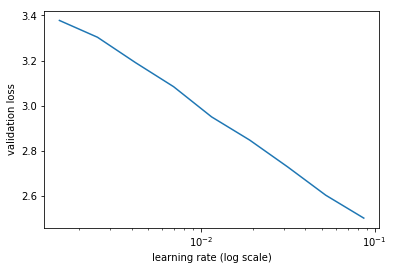

In [49]:
lrf = learn.lr_find(1e-5,100)
learn.sched.plot()

In [50]:
lr = 2e-2
learn.fit(lr, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                 
    0      1.251856   0.618705   0.806     


[array([0.61871]), 0.8059999990463257]

In [51]:
#unfreeze a few layers 
lr = 2e-2
lr = np.array([lr/1000,lr/100, lr])
learn.freeze_to(-2)
learn.fit(lr/5, 1 , cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.837065   0.544024   0.808     


[array([0.54402]), 0.8079999995231628]

In [52]:
learn.unfreeze()
learn.fit(lr/5, 1, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.633418   0.567325   0.814     
    1      0.448331   0.527491   0.826                     


[array([0.52749]), 0.8260000023841858]

In [53]:
learn.save("Largest_Item_Classifier")

In [54]:
learn.load("Largest_Item_Classifier")

In [55]:
x,y = next(iter(md.val_dl))
probs = F.softmax(predict_batch(learn.model, x), -1)
x, preds = to_np(x), to_np(probs)
preds = np.argmax(preds, -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


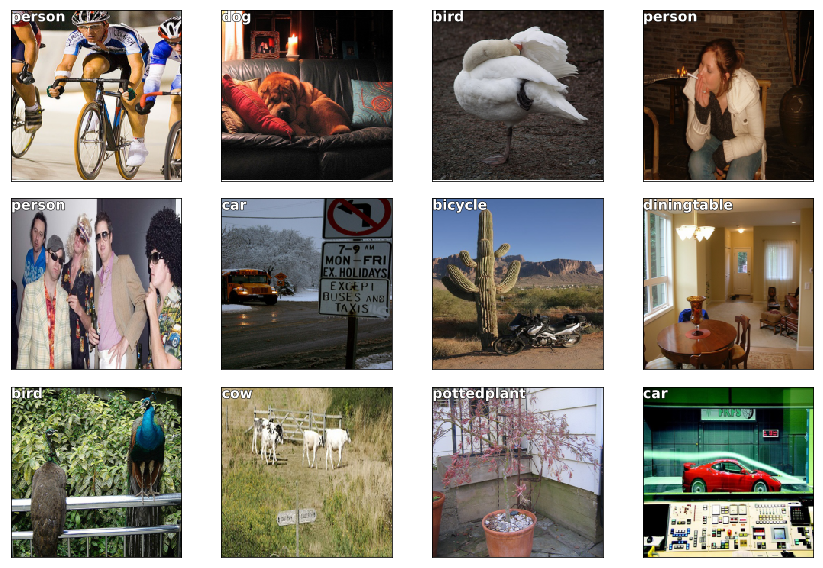

In [56]:
#visualize predictions by showing image with text drawn on 
fig, axes = plt.subplots(3,4,figsize=(12,8))

#flatten into 12 element array instead 
for i, ax in enumerate(axes.flat): 
    image = md.val_ds.denorm(x)[i] #ith element from minibatch is denormalized
    caption = md.classes[preds[i]]
    ax = show_img(image, ax=ax)
    draw_text(ax, (0,0), caption)
plt.tight_layout()
    

### Largest Object Localization

In [25]:
#create a CSV with filename and boundingbox for training
BB_CSV = PATH/'tmp/largest_bboxes.csv'
bb = np.array([trn_lrg_anno[o][0] for o in trn_ids])
bbs = [' '.join(str(p) for p in o) for o in bb] #converts bb to strings 

df = pd.DataFrame({"fn":[trn_fns[o] for o in trn_ids],
                  "bbox":bbs}, columns=["fn","bbox"])
df.to_csv(BB_CSV,index=False)

BB_CSV.open().readlines()[:5] #return first 5 lines

['fn,bbox\n',
 '000012.jpg,96 155 269 350\n',
 '000017.jpg,77 89 335 402\n',
 '000023.jpg,1 2 461 242\n',
 '000026.jpg,124 89 211 336\n']

In [26]:
f_model = resnet34
sz = 224
bs = 64

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y = TfmType.COORD)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True)
#continuous=True tells fastai that this is a regression problem (dont one hot)
#automatically uses MSE as loss 

In [61]:
x,y = next(iter(md.val_dl))
image = md.val_ds.denorm(to_np(x))[0]
box = bbox_npstyle(to_np(y[0]))
b

array([  8, 106, 505, 367])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


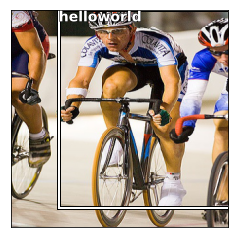

In [62]:
ax = show_img(image)
draw_rect(ax,box)
draw_text(ax,box[:2],'helloworld')

In [63]:
new_head = nn.Sequential(Flatten(), nn.Linear(25088,4))
learn = ConvLearner.pretrained(f_model,md,custom_head=new_head)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss() #L2 loss squares errors, L1 loss doesnt so less penalty 

 91%|█████████ | 29/32 [00:11<00:01,  2.58it/s, loss=342] 

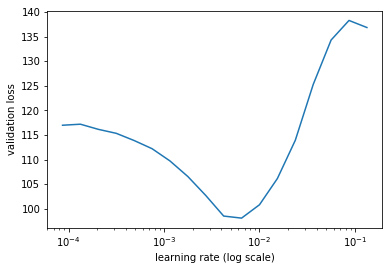

In [64]:
learn.lr_find()
learn.sched.plot(5)

epoch      trn_loss   val_loss                            
    0      48.871134  34.411181 
    1      36.942322  28.138068                           
    2      30.748945  27.423866                           


epoch      trn_loss   val_loss                            
    0      87.982358  799110331140931.6


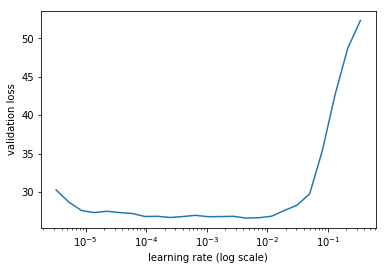

In [65]:
lr = 2e-3 
learn.fit(lr, 2, cycle_len = 1, cycle_mult=2)

lrs = np.array([lr/100,lr/10,lr])
learn.freeze_to(-2)
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [66]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)
learn.freeze_to(-3)
learn.fit(lrs, 1, cycle_len=2)

epoch      trn_loss   val_loss                            
    0      25.715969  23.194792 
    1      21.688397  21.188975                           
    2      17.703618  20.491089                           


epoch      trn_loss   val_loss                            
    0      17.426677  22.730487 
    1      15.026046  20.037188                           


[array([20.03719])]

In [69]:
learn.save('Largest Bounding Box Classifier')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


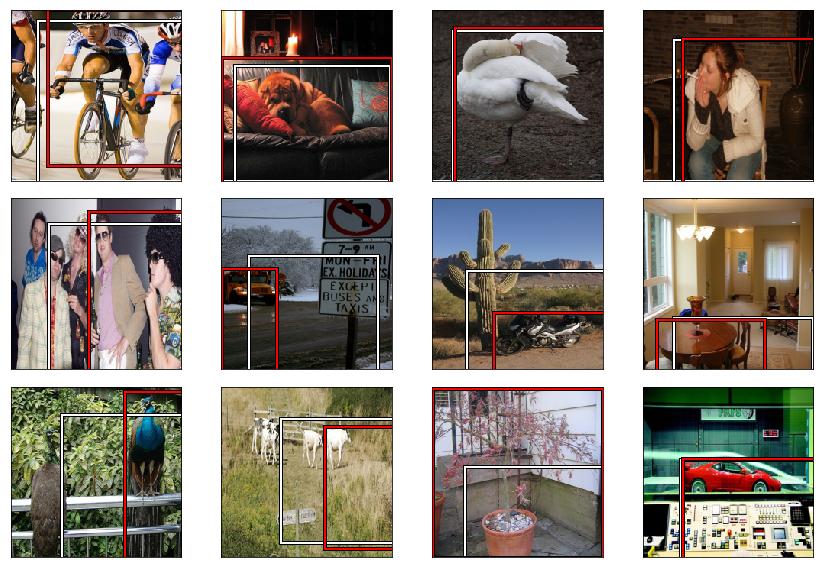

In [70]:
#Visualize the results
x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bbox_npstyle(preds[i])
    b_corr = bbox_npstyle(y[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
    draw_rect(ax, b_corr, edgecolor='red')
plt.tight_layout()

### Largest Object Detection

Three main parts to deep learning are   
1)The data  
2)The arch  
3)The loss fn  

In [37]:
f_model = resnet34
sz = 224
bs = 64 
val_idxs = get_cv_idxs(len(trn_ids))
tfm_y = TfmType.COORD

#TfmType.COORd tells that this a coordinate and must be transformed appropiately 
tfm_y = TfmType.COORD
augs = [RandomFlip(tfm_y=tfm_y),
        RandomRotate(3, p=0.5, tfm_y=tfm_y),
        RandomLighting(0.05,0.05, tfm_y=tfm_y)]

In [38]:
#create md for image->bbox and for image-> class then add together  
tfms = tfms_from_model(f_model, sz, tfm_y=tfm_y, 
                       aug_tfms=augs, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, bs=bs,
                                  val_idxs=val_idxs, continuous=True)

md2 = ImageClassifierData.from_csv(PATH,JPEGS,CSV, 
                                   tfms=tfms_from_model(f_model, sz))

In [39]:
#Datasets have __len__ and __getitem__ instance methods by definition 
class MDConcat (Dataset):
    #recieve data set and add second label to existing set 
    def __init__(self, ds, y2): self.ds, self.y2 = ds, y2
    def __len__(self): return len(self.ds)
    def __getitem__(self, index):
        x,y = self.ds[index]
        return(x,(y,self.y2[index])) #returns image, plus the bbox and class

In [40]:
#use above method to add together md and md2 based on image 
trn_ds2 = MDConcat(md.trn_ds, md2.trn_y)
val_ds2 = MDConcat(md.val_ds, md2.val_y)

trn_ds2[0][1]

(array([ 64.,  70., 178., 155.], dtype=float32), 6)

In [41]:
#replace dataloader datasets
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

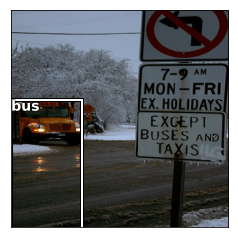

In [42]:
x,y = next(iter(md.val_dl))
idx = 5
ima = md.val_ds.ds.denorm(to_np(x))[idx]
b = bbox_npstyle(to_np(y[0][idx])); b
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], md2.classes[y[1][idx]])

In [43]:
#set up the arch
custom_head = nn.Sequential( Flatten(),
                            nn.ReLU(),
                            nn.Dropout(0.5),
                            nn.Linear(25088, 256),
                            nn.ReLU(),
                            nn.BatchNorm1d(256),
                            nn.Dropout(0.5),
                            nn.Linear(256, 4+len(cats))
)

model = ConvnetBuilder(f_model, 0, 0, 0, custom_head=custom_head)


#create conv learner to train 
learn = ConvLearner(md, model)
learn.opt_fn = optim.Adam


In [44]:
#setup the loss function (combine both losses)
def detn_loss(input,target):
    #note were working in minibatches
    bb_t, c_t = target
    bb_i, c_i = input[:,:4], input[:,4:] 
    bb_i = F.sigmoid(bb_i) * 224 #push between 0 and 1, multiply by image size
    return F.cross_entropy(c_i, c_t) * 20 + F.l1_loss(bb_i, bb_t)

#additional metrics 
def detn_l1 (input,target):
    bb_t, _ = target
    bb_i = input[:,:4]
    bb_i = F.sigmoid(bb_i) * 224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_accuracy(input, target):
    _, c_t = target
    c_i = input[:,4:]
    return accuracy(c_i,c_t)

learn.crit = detn_loss
learn.metrics = [detn_accuracy, detn_l1]

 94%|█████████▍| 30/32 [00:12<00:00,  2.39it/s, loss=220] 

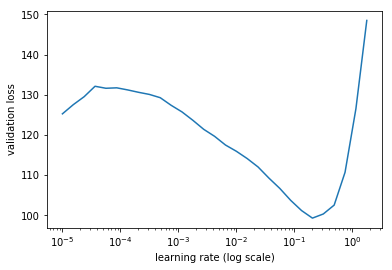

In [45]:
learn.lr_find(end_lr=10)
learn.sched.plot(n_skip = 0, n_skip_end=0)

In [46]:
lr = 1e-2 
learn.fit(lr, 1, cycle_len=3, cycle_mult=2, use_clr=(32,5))

epoch      trn_loss   val_loss   detn_accuracy detn_l1    
    0      73.419802  43.050887  0.806      30.29429  
    1      52.580882  36.785548  0.82       25.383154     
    2      43.908415  35.249109  0.824      24.510239     


[array([35.24911]), 0.8240000023841858, 24.510239181518553]

In [47]:
lr = 1e-2 
learn.fit(lr, 1, cycle_len=3, cycle_mult=2, use_clr=(32,5))

epoch      trn_loss   val_loss   detn_accuracy detn_l1    
    0      38.909421  43.357632  0.8        29.106748 
    1      36.398366  35.974763  0.818      24.834494     
    2      33.322734  34.235402  0.826      23.724658     


[array([34.2354]), 0.8259999976158142, 23.724658172607423]

In [48]:
learn.save('SingleObjectDetector_0')
learn.freeze_to(-2)

lrs = np.array([lr/100, lr/10, lr])
learn.fit(lrs/5, 1, cycle_len=5, use_clr=(32,10))

epoch      trn_loss   val_loss   detn_accuracy detn_l1    
    0      32.221576  35.32614   0.788      22.734903 
    1      28.615659  32.393292  0.84       21.192802     
    2      25.629161  31.89653   0.848      20.64099      
    3      23.007636  30.498157  0.84       19.920367     
    4      20.706069  30.311114  0.832      19.622671     


[array([30.31111]), 0.8320000014305114, 19.622671432495117]

In [49]:
learn.unfreeze()
learn.fit(lrs/10, 1, cycle_len=10, use_clr=(32,10))

epoch      trn_loss   val_loss   detn_accuracy detn_l1    
    0      18.655174  30.983014  0.832      19.842835 
    1      18.439785  31.46216   0.84       19.709937     
    2      17.499184  31.123161  0.84       19.621185     
    3      16.620596  30.63378   0.834      19.253687     
    4      15.746269  30.671196  0.838      19.665529     
    5      15.084098  30.684196  0.826      19.02614      
    6      14.27472   30.286562  0.826      18.694416     
    7      13.771544  30.135454  0.83       18.983398     
    8      13.385103  30.221647  0.836      18.627985     
    9      12.899547  29.78063   0.844      18.612171     


[array([29.78063]), 0.8439999995231628, 18.612170753479003]

In [50]:
learn.save("SingleObjectDetector_1")
learn.load("SingleObjectDetector_1")

In [51]:
y = learn.predict()
x, _ = next(iter(md.val_dl))

In [52]:
from scipy.special import expit
#for 3,4 subplots take each and show bounding box as well as class for largest
